### Importing Libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import os

import seaborn as sns

%run helpFunction.ipynb

UsageError: Line magic function `%` not found.


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[]


### Konfiguration Settings

In [ ]:
image_size = (250, 250)
batch_size = 32

### Data Preprocessing

In [ ]:
path_with_sign = 'data/y'
path_without_sign = 'data/n'

In [ ]:
#Canny edge detection
def apply_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    tight = cv2.Canny(blurred, 140, 160)
    tight = cv2.resize(tight, image_size)
    tight = np.expand_dims(tight, axis=-1)
    
    return tight

In [ ]:
#Morphology Methode wurde angwendet
def apply_morphology(image, target_size=(250, 250)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 190, 210, cv2.THRESH_BINARY)
    
    kernel = np.ones((5,5), np.uint8)
    
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    
    image = cv2.resize(eroded, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [ ]:
def black_and_white(image, target_size=(250, 250)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [ ]:
def load_images_from_folder(folder, label, target_size, type='normal'):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:             
            img = cv2.imread(img_path)
            if type == 'canny':
                img = apply_canny(img)
            elif type == 'morphology':
                img = apply_morphology(img, target_size)
            elif type == 'normal':
                img = black_and_white(img, target_size)
            else:    
                raise ValueError(f"Unbekannter Typ '{type}'")
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
images_with_sign_canny, labels_with_sign_canny = load_images_from_folder(path_with_sign, 0, image_size, type='canny')
images_without_sign_canny, labels_without_sign_canny = load_images_from_folder(path_without_sign, 1, image_size, type='canny')

images_with_sign_morphology, labels_with_sign_morphology = load_images_from_folder(path_with_sign, 0, image_size, type='morphology')
images_without_sign_morphology, labels_without_sign_morphology = load_images_from_folder(path_without_sign, 1, image_size, type='morphology')

images_with_sign_normal, labels_with_sign_normal = load_images_from_folder(path_with_sign, 0, image_size, type='normal')
images_without_sign_normal, labels_without_sign_normal = load_images_from_folder(path_without_sign, 1, image_size, type='normal')


images_with_sign_canny = np.array(images_with_sign_canny)
images_without_sign_canny = np.array(images_without_sign_canny)
images_with_sign_morphology = np.array(images_with_sign_morphology)
images_without_sign_morphology = np.array(images_without_sign_morphology)
images_with_sign_normal = np.array(images_with_sign_normal)
images_without_sign_normal = np.array(images_without_sign_normal)

images_with_sign = np.concatenate((images_with_sign_canny, images_with_sign_morphology, images_with_sign_normal), axis=-1)
images_without_sign = np.concatenate((images_without_sign_canny, images_without_sign_morphology, images_without_sign_normal), axis=-1)
labels_with_sign = np.array(labels_with_sign_canny)
labels_without_sign = np.array(labels_without_sign_canny)

all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

print("Shape of all_images tensor:", all_images.shape)
print("Shape of all_labels tensor:", all_labels.shape)

Shape of all_images tensor: (1456, 250, 250, 3)
Shape of all_labels tensor: (1456,)


### Data Normalization

In [ ]:
all_images = all_images.astype('float32') / 255.0
all_images.shape

(1456, 250, 250, 3)

In [ ]:
namelabels = {0: 'Wartelinie', 1: 'keine Wartelinie'}
def show_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(namelabels[label])
    plt.show()

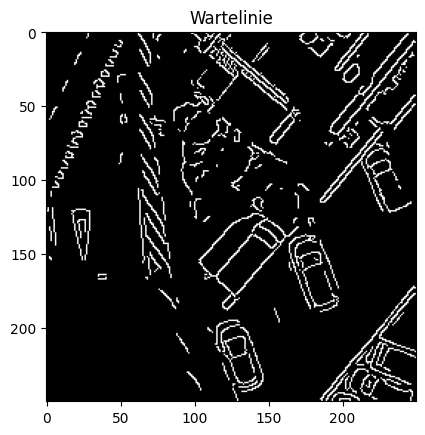

In [ ]:
show_image(images_with_sign_canny[4], labels_with_sign_canny[4])

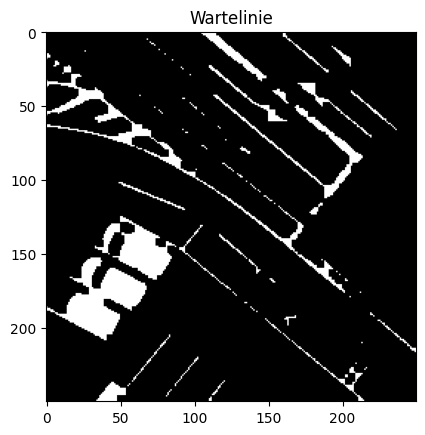

In [ ]:
show_image(images_with_sign_morphology[3], labels_with_sign_morphology[3])

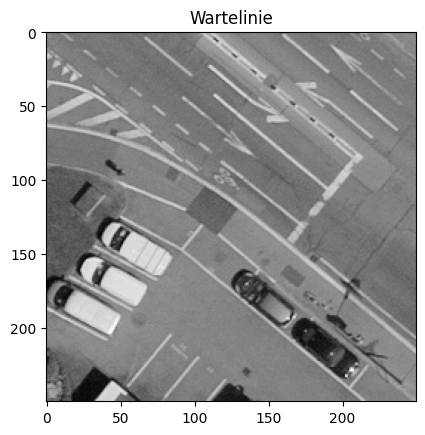

In [ ]:
show_image(images_with_sign_normal[3], labels_with_sign_normal[3])

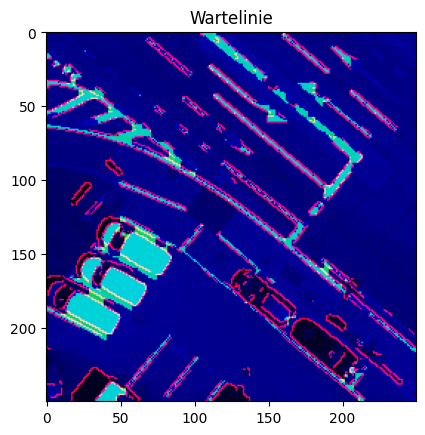

In [ ]:
show_image(all_images[3], all_labels[3])

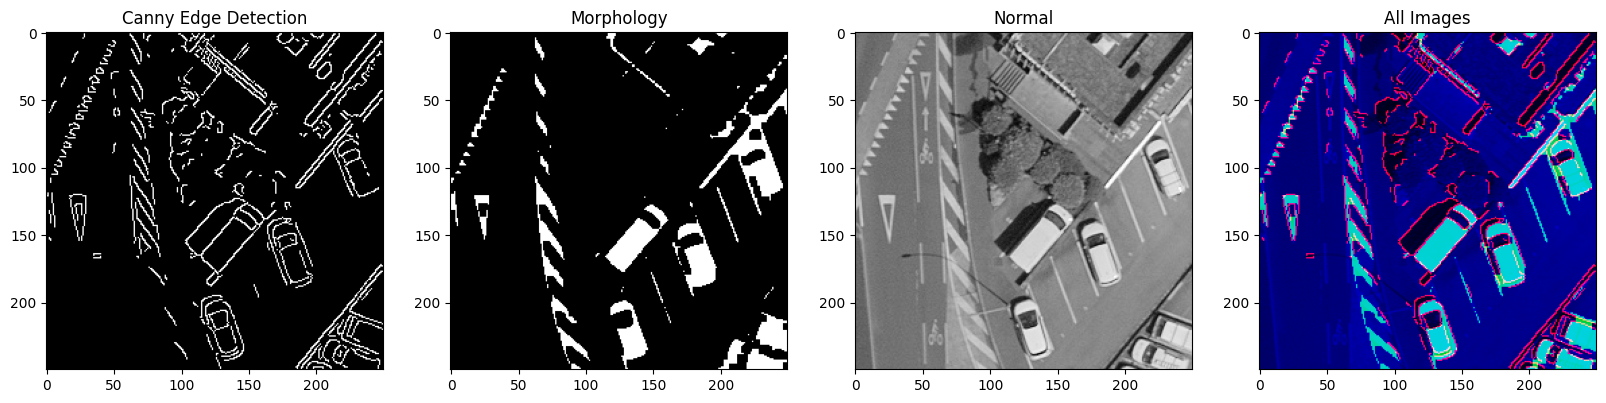

In [ ]:

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(images_with_sign_canny[1], cmap='gray')
ax[0].set_title('Canny Edge Detection')

ax[1].imshow(images_with_sign_morphology[1], cmap='gray')
ax[1].set_title('Morphology')

ax[2].imshow(images_with_sign_normal[1], cmap='gray')
ax[2].set_title('Black and White')

ax[3].imshow(all_images[1], cmap='gray')
ax[3].set_title('All Images Combined')

plt.show()

### Data Splitting

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

In [ ]:
train_images.shape, test_images.shape

((1164, 250, 250, 3), (292, 250, 250, 3))

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)

### Vortrainiertes Modell

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=None)
base_model.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x) 

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.10
)


Epoch 1/20


33/33 [==============================] - 21s 532ms/step - loss: 3.9166 - accuracy: 0.6437 - val_loss: 3.8693 - val_accuracy: 0.5299
Epoch 2/20
33/33 [==============================] - 16s 486ms/step - loss: 3.6884 - accuracy: 0.7354 - val_loss: 3.8220 - val_accuracy: 0.5470
Epoch 3/20
33/33 [==============================] - 16s 484ms/step - loss: 3.5764 - accuracy: 0.7832 - val_loss: 3.6822 - val_accuracy: 0.6325
Epoch 4/20
33/33 [==============================] - 16s 486ms/step - loss: 3.4768 - accuracy: 0.8061 - val_loss: 3.5761 - val_accuracy: 0.7009
Epoch 5/20
33/33 [==============================] - 16s 482ms/step - loss: 3.3965 - accuracy: 0.8195 - val_loss: 3.5029 - val_accuracy: 0.7179
Epoch 6/20
33/33 [==============================] - 16s 487ms/step - loss: 3.3377 - accuracy: 0.8214 - val_loss: 3.3957 - val_accuracy: 0.7692
Epoch 7/20
33/33 [==============================] - 16s 494ms/step - loss: 3.2428 - accuracy: 0.8405 - val_loss: 3.3185 - val_accuracy: 0.76

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

10/10 [==============================] - 4s 398ms/step - loss: 2.6993 - accuracy: 0.8459
Testgenauigkeit: 0.8459, Testverlust: 2.6993


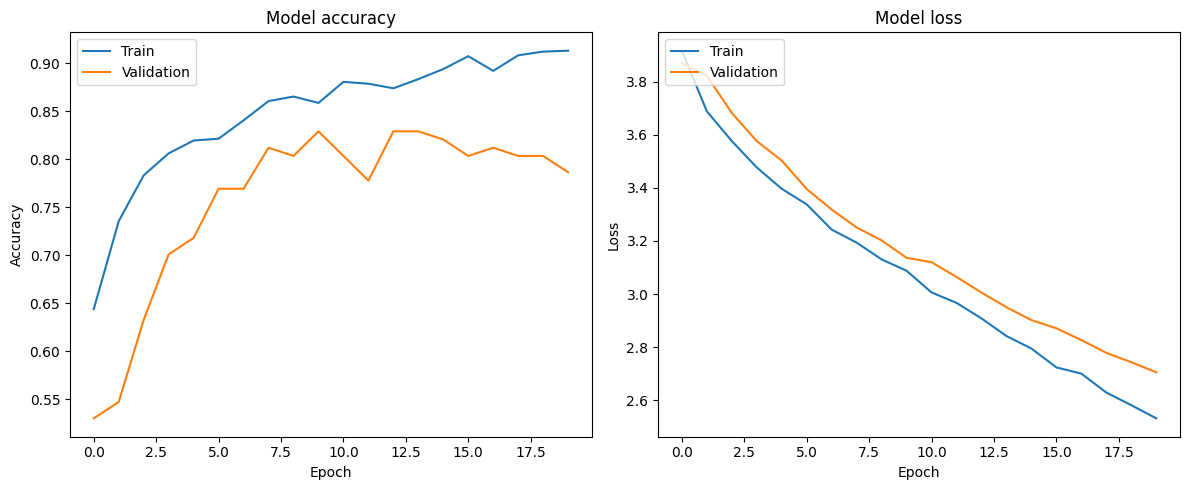

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()


10/10 [==============================] - 5s 398ms/step
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       147
           1       0.83      0.87      0.85       145

    accuracy                           0.85       292
   macro avg       0.85      0.85      0.85       292
weighted avg       0.85      0.85      0.85       292



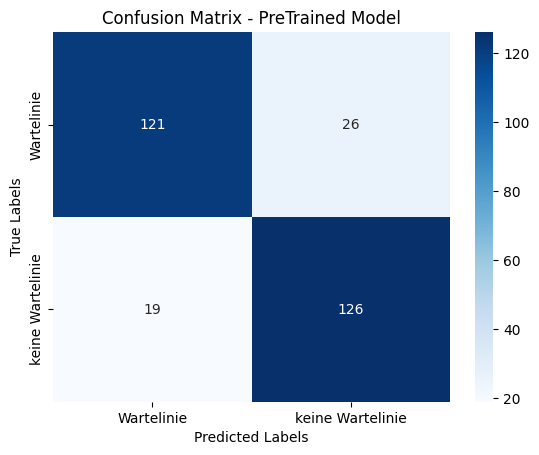

In [ ]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

prediction_csv(test_labels, predictions, 'InceptionV3')

In [ ]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=namelabels.values(), yticklabels=namelabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - InceptionV3 Model')
plt.show()